# Process Input Scenes Using CGI_HLC_PSFs

In [2]:
from importlib import reload

import hlc_processing
reload(hlc_processing)

import disk_processing
reload(disk_processing)

import astropy.io.fits as fits
import astropy.units as u
import os
import numpy as np
import poppy.utils as utils
import poppy
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from matplotlib.colors import LogNorm
import glob
import time
from utils import displ_scale  
from scipy.interpolate import RegularGridInterpolator
import traceback

plt.rcParams.update({'image.origin': 'lower',
                     'image.interpolation':"nearest"})

my_home_dir = os.getcwd() # gets the current working directory
print(my_home_dir)

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection


In [3]:
thresh = 1e32
localzodi = 5.2e-11 #Jy/pix (22 mags/sq as)

# Define the resolution and pixel scale
det_oversample = 4
D = 2.3631*u.m
lambda_C = 575*u.nm
resel = ((lambda_C/D)*u.radian).to(u.arcsec) # puts the reselution in arcseconds
print(resel)
out_pixscale = (resel/det_oversample).value

0.05018926985403936 arcsec


In [4]:
dmodels = glob.glob(my_home_dir+"\DebesModels\*\**.fits",recursive = True) # collect the debes_models
#for i,debes_model in enumerate(debes_models): print(i,debes_model)


In [5]:
# Read in the file of PSFs and the file containing the offset values which are in units of Lambda/D at first
psfs_file_name = my_home_dir + "\offset_psfs\CGI_HLC_PSFs\\" + "20180718_hlc_nfov_PSFs_1Dcube.fits"
print(psfs_file_name)
info_file_name = my_home_dir + "\offset_psfs\CGI_HLC_PSFs\\" + "20180718_hlc_nfov_PSFs_1Dcube_info.fits"
print(info_file_name)


C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\offset_psfs\CGI_HLC_PSFs\20180718_hlc_nfov_PSFs_1Dcube.fits
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\offset_psfs\CGI_HLC_PSFs\20180718_hlc_nfov_PSFs_1Dcube_info.fits


In [43]:
# Open the the two fits files
psfs_file = fits.open(psfs_file_name)
info_file = fits.open(info_file_name)

# View the headers of the two files
print("PSFs Header: ")
for i, val in enumerate(psfs_file[0].header,0):
    print(i,val)

print("\nInfo Header: ")
for i, val in enumerate(info_file[0].header,0):
    print(i,val)
    
print("\n")
print(info_file[0].header["SAMPLING"])



PSFs Header: 
0 SIMPLE
1 BITPIX
2 NAXIS
3 NAXIS1
4 NAXIS2
5 NAXIS3
6 EXTEND
7 COMMENT
8 COMMENT

Info Header: 
0 SIMPLE
1 BITPIX
2 NAXIS
3 NAXIS1
4 NAXIS2
5 PUPIL
6 CGI_DSGN
7 SYS_ABER
8 DH_STATU
9 SAMPLING


DH SAMPLING = 0.2 PXL_PER_LAMD


11.0
552.0819702148438 marcsec


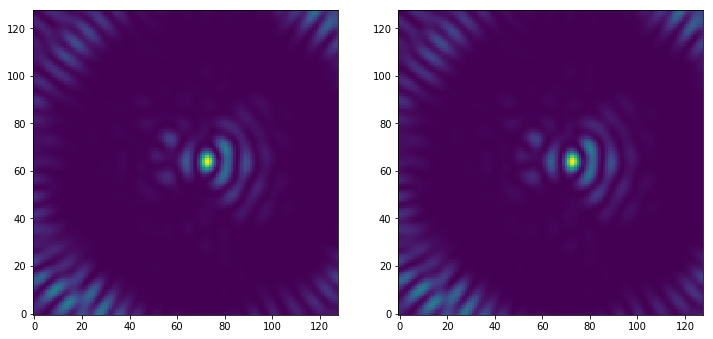

In [7]:
psfs = fits.getdata(psfs_file_name)
psfs_info = fits.getdata(info_file_name)

plt.figure(figsize=[12,12])
i = 30
# move the axis of the PSFs to be compatible with the interpolating function
plt.subplot(121)
plt.imshow(psfs[i,:,:])

# move the axis
psfs = np.moveaxis(psfs,0,-1)

plt.subplot(122)
plt.imshow(psfs[:,:,i])

# Get the offset values which are in the second column of the psfs_info data and convert to arcseconds
offsets_LD = psfs_info[:,1]
offsets_MAS = offsets_LD*((lambda_C/D)*u.radian).to(u.milliarcsecond)

fov_LD = offsets_LD[84]
print(fov_LD)
fov_MAS = offsets_MAS[84]
print(fov_MAS)

In [8]:
xmas = offsets_MAS

n = 128

x = range(n)
y = range(n)
z = xmas

my_interpolating_function = RegularGridInterpolator((x, y, z), 
                                                    psfs,
                                                    bounds_error = False,
                                                    method = "linear",
                                                    fill_value = 0)

my_interpolating_function_n = RegularGridInterpolator((x, y, z), 
                                                      psfs,
                                                      bounds_error = False,
                                                      method = "nearest", #~2x faster than linear
                                                      fill_value = 0)

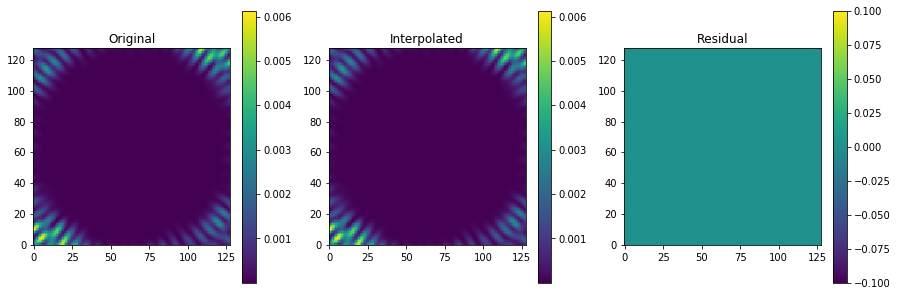

In [9]:
# Now do the interpolation
n = 128

x = range(n)
y = range(n)

grid = np.meshgrid(x,y)
pts = np.vstack([np.vstack([grid[0].flatten(),grid[1].flatten()]),0*np.ones(len(grid[0].flatten()))]).T
interpped = my_interpolating_function(pts).reshape(n,n).T

# Now display everything
plt.figure(figsize=[15,5])

# Plot the original PSF
plt.subplot(131)
plt.title("Original")
plt.imshow(psfs[:,:,0])
plt.colorbar()

# Plot the interpolated PSF
plt.subplot(132)
plt.title("Interpolated")
plt.imshow(interpped)
plt.colorbar()

# Plot the interpolated - original PSF
plt.subplot(133)
plt.title("Residual")
plt.imshow(interpped-psfs[:,:,0])
plt.colorbar()

plt.show()

In [10]:
# Use the sampling information to get the HLC_plate_scale
HLC_plate_scale_LD = 1/0.2 # get the plate scale in L/D per pixel
HLC_plate_scale_AS = 1/(HLC_plate_scale_LD/resel)
print(HLC_plate_scale_AS)

mask_radius = 0.7/HLC_plate_scale_AS.value
print(mask_radius)

0.010037853970807873 arcsec
69.73602146790965


## Make two planets with offsets of 50mas and 100mas.
### The first row is done using linear interpolation and the second row is using nearest interpolation.

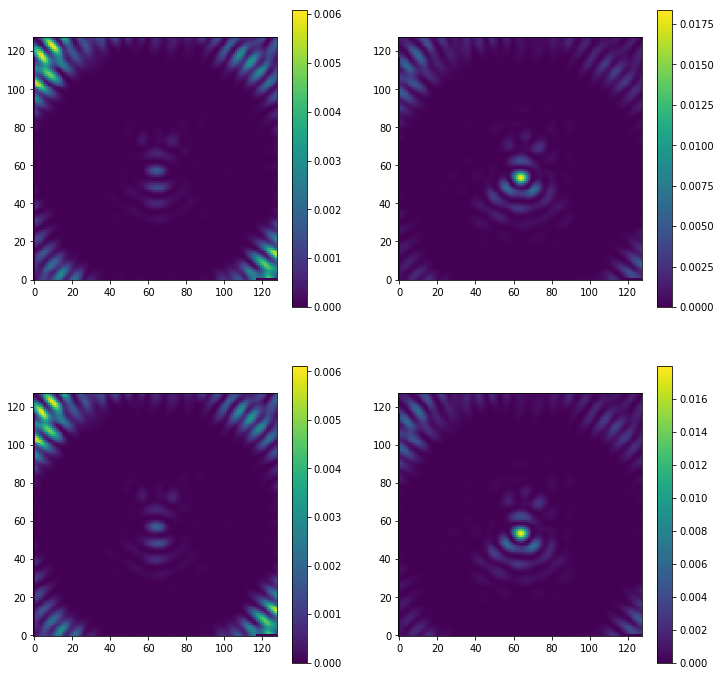

In [11]:
reload(hlc_processing)

plt.figure(figsize = [12,12])

planet1 = hlc_processing.closest_monochrome_PSF(50*u.milliarcsecond,0*u.milliarcsecond,
                                                my_interpolating_function,
                                                xmas,
                                                HLC_plate_scale_AS,
                                                n = 128,
                                                mask_radius = None)

plt.subplot(221)
plt.imshow(planet1)
plt.colorbar()

planet2 = hlc_processing.closest_monochrome_PSF(100*u.milliarcsecond,0*u.milliarcsecond,
                                                my_interpolating_function,
                                                xmas,
                                                HLC_plate_scale_AS,
                                                n = 128,
                                                mask_radius = None)

plt.subplot(222)
plt.imshow(planet2)
plt.colorbar()

planet1_n = hlc_processing.closest_monochrome_PSF(50*u.milliarcsecond,0*u.milliarcsecond,
                                                my_interpolating_function_n,
                                                xmas,
                                                HLC_plate_scale_AS,
                                                n = 128,
                                                mask_radius = None)

plt.subplot(223)
plt.imshow(planet1_n)
plt.colorbar()

planet2_n = hlc_processing.closest_monochrome_PSF(100*u.milliarcsecond,0*u.milliarcsecond,
                                                my_interpolating_function_n,
                                                xmas,
                                                HLC_plate_scale_AS,
                                                n = 128,
                                                mask_radius = None)

plt.subplot(224)
plt.imshow(planet2_n)
plt.colorbar()


## Subtract the nearest from the linearly interpolated planets.

Max difference for planet 1 is 0.00020341390180135402
Max difference is located at [56],[64]
The percent difference from the linear interpolation is [0.12603151]


Max difference for planet 2 is 0.0007395121888110912
Max difference is located at [51],[64]
The percent difference from the linear interpolation is [0.06598443]


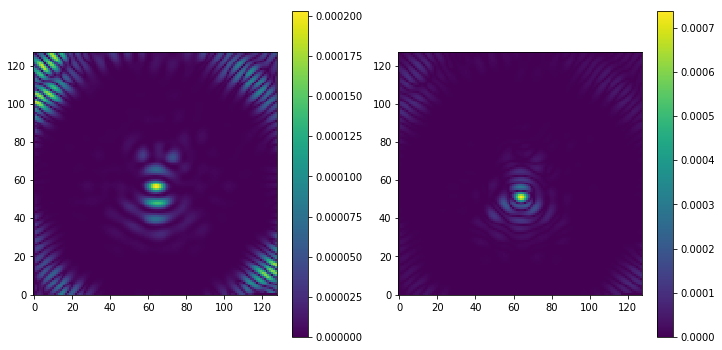

In [12]:
plt.figure(figsize = [12,6])

planet1_diff = np.abs(planet1-planet1_n)
plt.subplot(121)
plt.imshow(planet1_diff)
plt.colorbar()

planet2_diff = np.abs(planet2-planet2_n)
plt.subplot(122)
plt.imshow(planet2_diff)
plt.colorbar()

max_loc_1 = np.where(planet1_diff == planet1_diff.max())
print("Max difference for planet 1 is {}".format(planet1_diff.max()))
print("Max difference is located at {},{}".format(max_loc_1[0],max_loc_1[1]))
print("The percent difference from the linear interpolation is {}".format(planet1_diff.max()/planet1[max_loc_1]))
#print(planet1[56,64],planet1_n[56,64])

print("\n")

max_loc_2 = np.where(planet2_diff == planet2_diff.max())
print("Max difference for planet 2 is {}".format(planet2_diff.max()))
print("Max difference is located at {},{}".format(max_loc_2[0],max_loc_2[1]))
print("The percent difference from the linear interpolation is {}".format(planet2_diff.max()/planet2[max_loc_2]))
#print(planet2[51,64],planet2_n[51,64])


## Save the 100mas planet to a fits file

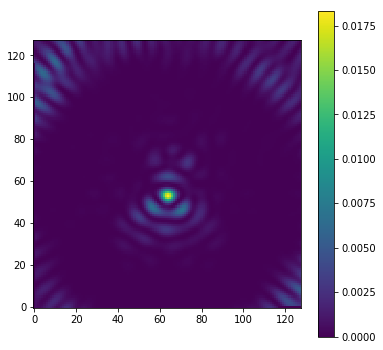

In [13]:
plt.figure(figsize=[6,6])

planet_100mas = hlc_processing.closest_monochrome_PSF(100*u.milliarcsecond,0*u.milliarcsecond,
                                                      my_interpolating_function,
                                                      xmas,
                                                      HLC_plate_scale_AS,
                                                      n=128,
                                                      mask_radius = None)

plt.imshow(planet_100mas)
plt.colorbar()

planet_fits_name = my_home_dir + "\planets\\" + "planet_100mas_CGI_HLC.fits"
fits.writeto(planet_fits_name,planet_100mas,overwrite=True)

## Side by side comparison of planets using CGI vs OS5

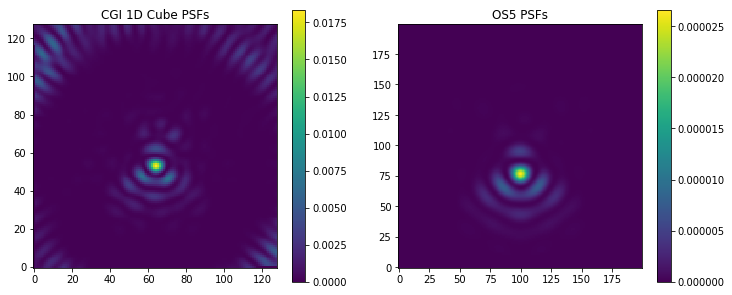

In [14]:
planet_fits_name_CGI = my_home_dir + "\planets\\" + "planet_100mas_CGI_HLC.fits"
planet_CGI = fits.getdata(planet_fits_name_CGI)

planet_fits_name_OS5 = my_home_dir + "\planets\\" + "planet_100mas_OS5_3.2.fits"
planet_OS5 = fits.getdata(planet_fits_name_OS5)

plt.figure(figsize = [12,5])
plt.subplot(121)
plt.imshow(planet_CGI)
plt.title("CGI 1D Cube PSFs")
plt.colorbar()

plt.subplot(122)
plt.imshow(planet_OS5)
plt.title("OS5 PSFs")
plt.colorbar()


## Define the paths for the zodi files

In [38]:
zodi_path = my_home_dir + "\zodipics\\"
print(zodi_path)

output_path_10pc03mas01alpha = my_home_dir + "\zodipics_HLC_outputs\\" + "zodipic_10pc03mas01alpha\\"
print(output_path_10pc03mas01alpha)

output_path_10pc03mas = my_home_dir + "\zodipics_HLC_outputs\\" + "zodipic_10pc03mas\\"
print(output_path_10pc03mas)

output_path_03pc03mas01alpha = my_home_dir + "\zodipics_HLC_outputs\\" + "zodipic_03pc03mas01alpha\\"
print(output_path_03pc03mas01alpha)

output_path_03pc03mas = my_home_dir + "\zodipics_HLC_outputs\\" + "zodipic_03pc03mas\\"
print(output_path_03pc03mas)

# Also define mask and core_mask radii
core_mask_radius = .15*u.arcsec # 150mas
mask_radius = mask_radius

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics\
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics_HLC_outputs\zodipic_10pc03mas01alpha\
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics_HLC_outputs\zodipic_10pc03mas\
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics_HLC_outputs\zodipic_03pc03mas01alpha\
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics_HLC_outputs\zodipic_03pc03mas\


## zodipic_\*pc\*mas\*.fits

### Output files:
zodipic_\*pc\*mas\*\_linear_HLC.fits

zodipic_\*pc\*mas\*\_linear_input.fits

zodipic_\*pc\*mas\*\_linear_coremaksed_HLC.fits

zodipic_\*pc\*mas\*\_linear_coremaksed_input.fits


C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\CGI_HLC_outputs\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_linear_HLC.fits
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\CGI_HLC_outputs\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_linear_input.fits
227.89456701278687


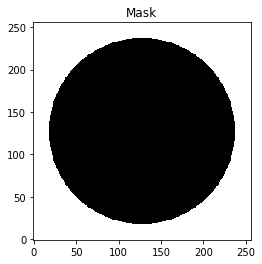

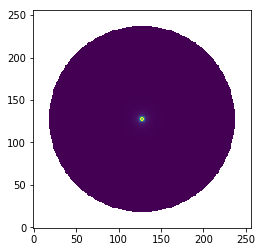

In [36]:
reload(hlc_processing)

zodi_fname = "zodipic_10pc03mas01alpha.fits"
zodi_file = zodi_path + zodi_fname

im_name = output_path_10pc03mas01alpha + zodi_fname[:-5] + "_linear_HLC.fits"
print(im_name)

zodi_name = output_path_10pc03mas01alpha + zodi_fname[:-5] + "_linear_input.fits"
print(zodi_name)

start_time = time.time()
    
im,zodi = hlc_processing.fit_to_hlc(zodi_file,
                                    my_interpolating_function,
                                    xmas,
                                    HLC_plate_scale_AS,
                                    n = 128,
                                    thresh = thresh,
                                    display=True)

zodi_header = fits.getheader(zodi_file)
zodi_header["thresh"] = thresh
zodi_header["coremask"] = core_mask_radius.value

fits.writeto(im_name, im, overwrite=True, header=zodi_header) 
fits.writeto(zodi_name, zodi.filled(fill_value = 0), overwrite = True)

print(time.time()-start_time)

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\CGI_HLC_outputs\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_linear_coremasked_HLC.fits
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\CGI_HLC_outputs\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_linear_coremasked_input.fits
181.22943806648254


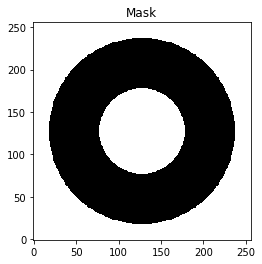

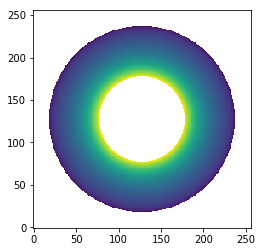

In [19]:
reload(hlc_processing)

zodi_fname = "zodipic_10pc03mas01alpha.fits"
zodi_file = zodi_path + zodi_fname

im_name = output_path_10pc03mas01alpha + zodi_fname[:-5] + "_linear_coremasked_HLC.fits"
print(im_name)

zodi_name = output_path_10pc03mas01alpha + zodi_fname[:-5] + "_linear_coremasked_input.fits"
print(zodi_name)

start_time = time.time()
    
im,zodi = hlc_processing.fit_to_hlc(zodi_file,
                                    my_interpolating_function,
                                    xmas,
                                    HLC_plate_scale_AS,
                                    n = 128,
                                    thresh = thresh,
                                    display=True,
                                    core_mask_radius=core_mask_radius)

zodi_header = fits.getheader(zodi_file)
zodi_header["thresh"] = thresh
zodi_header["coremask"] = core_mask_radius.value

fits.writeto(im_name, im, overwrite=True, header=zodi_header) 
fits.writeto(zodi_name, zodi.filled(fill_value = 0), overwrite = True)

print(time.time()-start_time)

## Compute difference between the linear and nearest interpolations for zodipic_10pc03mas01alpha.fits

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics_HLC_outputs\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_HLC.fits
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics_HLC_outputs\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_linear_HLC.fits

Max difference for planet 1 is 1.3309212354314247e-11
Max difference is located at [64],[42]
The percent difference from the linear interpolation is [0.51797967]%


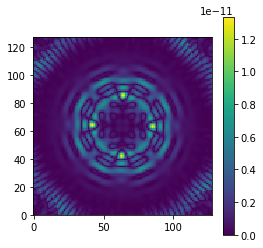

In [41]:
zodi_fname = "zodipic_10pc03mas01alpha.fits"

im_name = output_path_10pc03mas01alpha + zodi_fname[:-5] + "_HLC.fits"
print(im_name)

im_l_name = output_path_10pc03mas01alpha + zodi_fname[:-5] + "_linear_HLC.fits"
print(im_l_name)

im = fits.getdata(im_name)
im_l = fits.getdata(im_l_name)

diff = np.abs(im-im_l)

plt.figure(figsize = [4,4])
plt.imshow(diff)
plt.colorbar()

max_loc = np.where(diff == diff.max())
print("\nMax difference for planet 1 is {}".format(diff.max()))
print("Max difference is located at {},{}".format(max_loc[0],max_loc[1]))
print("The percent difference from the linear interpolation is {}%".format(100*diff.max()/im_l[max_loc]))


C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics_HLC_outputs\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_coremasked_HLC.fits
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics_HLC_outputs\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_linear_coremasked_HLC.fits

Max difference for planet 1 is 1.30149109308709e-11
Max difference is located at [64],[42]
The percent difference from the linear interpolation is [0.54867506]%


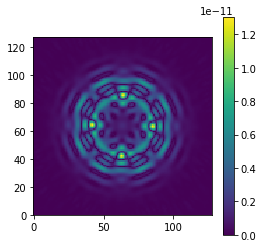

In [42]:
im_name = output_path_10pc03mas01alpha + zodi_fname[:-5] + "_coremasked_HLC.fits"
print(im_name)

im_l_name = output_path_10pc03mas01alpha + zodi_fname[:-5] + "_linear_coremasked_HLC.fits"
print(im_l_name)

im = fits.getdata(im_name)
im_l = fits.getdata(im_l_name)

diff = np.abs(im-im_l)

plt.figure(figsize = [4,4])
plt.imshow(diff)
plt.colorbar()

max_loc = np.where(diff == diff.max())
print("\nMax difference for planet 1 is {}".format(diff.max()))
print("Max difference is located at {},{}".format(max_loc[0],max_loc[1]))
print("The percent difference from the linear interpolation is {}%".format(100*diff.max()/im_l[max_loc]))


# Now to run the Debes Models

## First run Model_Annulus\annulus_inc60_r0.4.fits as an example

Running disk through HLC ...

Input file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Annulus\annulus_inc60_r0.4.fits

Output file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels_HLC\Model_Annulus\annulus_inc60_r0.4_HLC_5.fits

Thresh = 5
local zodi: 0

load_existing keyword False, throwing error to regenerate file.


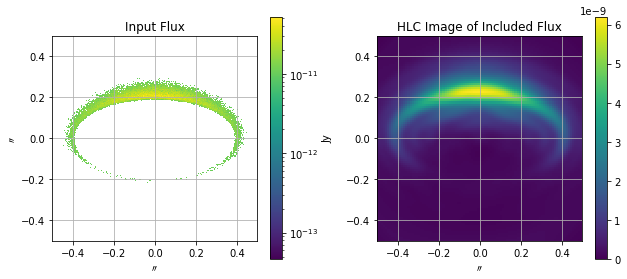

113.83067393302917


In [32]:
# Run it using linear first
reload(disk_processing)

thresh = 5

fitsfile = my_home_dir + "\DebesModels\\" + "Model_Annulus\\" + "annulus_inc60_r0.4.fits"

start_time = time.time()

im,zodi,outfits = disk_processing.disk_through_hlc(fitsfile,
                                                   my_interpolating_function,
                                                   xmas,
                                                   HLC_plate_scale_AS,
                                                   n = 128,
                                                   thresh=5,
                                                   display=True)

fits.writeto(outfits, im, overwrite = True)

end_time = time.time()
print(end_time-start_time)

Running disk through HLC ...

Input file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Annulus\annulus_inc60_r0.4.fits

Output file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels_HLC\Model_Annulus\annulus_inc60_r0.4_HLC_5.fits

Thresh = 5
local zodi: 0

load_existing keyword False, throwing error to regenerate file.


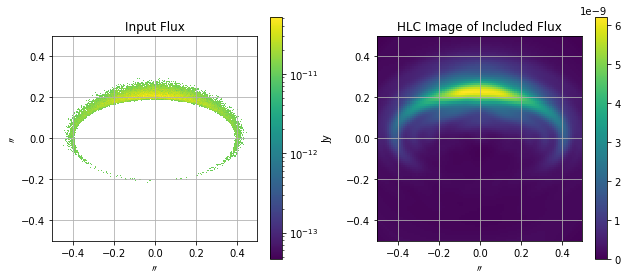

62.570415019989014


In [33]:
# Now run it using nearest
reload(disk_processing)

thresh = 5

fitsfile = my_home_dir + "\DebesModels\\" + "Model_Annulus\\" + "annulus_inc60_r0.4.fits"

start_time = time.time()

im,zodi,outfits = disk_processing.disk_through_hlc(fitsfile,
                                                   my_interpolating_function_n,
                                                   xmas,
                                                   HLC_plate_scale_AS,
                                                   n=128,
                                                   thresh=5,
                                                   display=True)

fitsfile_parts = fitsfile.split("\\")
outfits = my_home_dir + "\KianDebesModels_HLC\\" + fitsfile_parts[-2] + "\\" + fitsfile_parts[-1][:-5] + "_HLC_" + str(thresh) + '_nearest.fits'

fits.writeto(outfits, im, overwrite = True)

end_time = time.time()
print(end_time-start_time)

1.3119261423064718e-10
Max location in difference array is [85],[54]
Percentage of linearly interpped at the max differnce location is [2.21300463]%


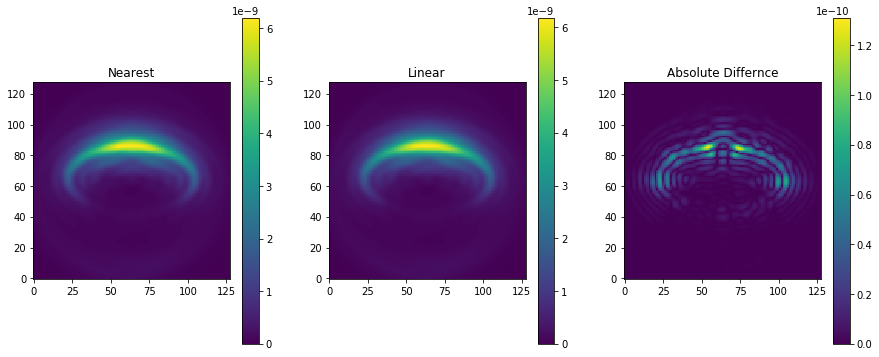

In [35]:
# Compare the linear and nearest interpolation results
fitsfile = my_home_dir + "\DebesModels\\" + "Model_Annulus\\" + "annulus_inc60_r0.4.fits"

fitsfile_parts = fitsfile.split("\\")

thresh = 5

outfits_n = my_home_dir + "\KianDebesModels_HLC\\" + fitsfile_parts[-2] + "\\" + fitsfile_parts[-1][:-5] + "_HLC_" + str(thresh) + '_nearest.fits'
outfits_l = my_home_dir + "\KianDebesModels_HLC\\" + fitsfile_parts[-2] + "\\" + fitsfile_parts[-1][:-5] + "_HLC_" + str(thresh) + '.fits'

im_n = fits.getdata(outfits_n)
im_l = fits.getdata(outfits_l)

diff = np.abs(im_n - im_l)

print(diff.max())

max_loc = np.where(diff == diff.max())
print("Max location in difference array is {},{}".format(max_loc[0],max_loc[1]))
print("Percentage of linearly interpped at the max differnce location is {}%".format(100*diff.max()/im_l[max_loc]))

plt.figure(figsize = [15,6])

plt.subplot(131)
plt.imshow(im_n)
plt.title("Nearest")
plt.colorbar()

plt.subplot(132)
plt.imshow(im_l)
plt.title("Linear")
plt.colorbar()

plt.subplot(133)
plt.imshow(diff)
plt.title("Absolute Differnce")
plt.colorbar()

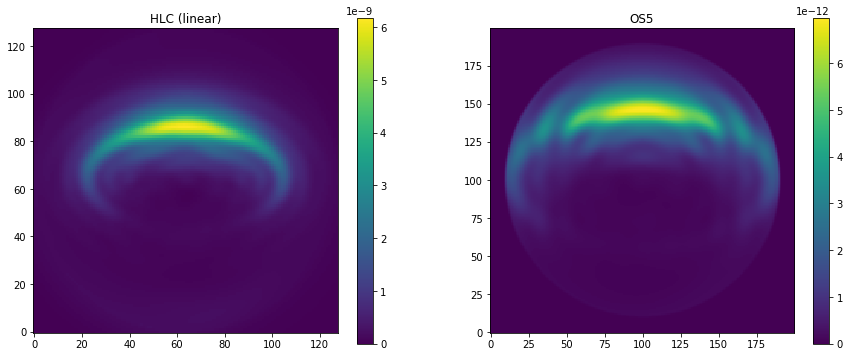

In [37]:
# Compare with that from OS5 PSFs

fitsfile = my_home_dir + "\DebesModels\\" + "Model_Annulus\\" + "annulus_inc60_r0.4.fits"
fitsfile_parts = fitsfile.split("\\")

outfits_HLC = my_home_dir + "\KianDebesModels_HLC\\" + fitsfile_parts[-2] + "\\" + fitsfile_parts[-1][:-5] + "_HLC_5.fits"
outfits_OS5 = my_home_dir + "\KianDebesModels_OS5\\" + fitsfile_parts[-2] + "\\" + fitsfile_parts[-1][:-5] + '_HLC_5.fits'

im_HLC = fits.getdata(outfits_HLC)
im_OS5 = fits.getdata(outfits_OS5)

plt.figure(figsize = [15,6])

plt.subplot(121)
plt.imshow(im_HLC)
plt.title("HLC (linear)")
plt.colorbar()

plt.subplot(122)
plt.imshow(im_OS5.T)
plt.title("OS5")
plt.colorbar()


# Now just run all the Debes Models

In [18]:
# Separate the files into the annulus, constanttau, gap, and ring files
dmodels_A = list()
dmodels_C = list()
dmodels_G = list()
dmodels_R = list()

for i,model in enumerate(dmodels):
    if "Annulus" in model: 
        dmodels_A.append(model)
    if "ConstantTau" in model: 
        dmodels_C.append(model)
    if "GAP" in model: 
        dmodels_G.append(model)
    if "Ring" in model: 
        dmodels_R.append(model)

dmodels_G

['C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_GAP\\gap_inc0_r0.2.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_GAP\\gap_inc30_r0.2.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_GAP\\gap_inc45_r0.2.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_GAP\\gap_inc60_r0.2.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_GAP\\gap_inc89_r0.2.fits']

In [19]:
dmodels_A_inc0 = list()
dmodels_A_inc30 = list()
dmodels_A_inc45 = list()
dmodels_A_inc60 = list()
dmodels_A_inc89 = list()

for i,model in enumerate(dmodels_A):
    if "inc0" in model:
        dmodels_A_inc0.append(model)
    if "inc30" in model:
        dmodels_A_inc30.append(model)
    if "inc45" in model:
        dmodels_A_inc45.append(model)
    if "inc60" in model:
        dmodels_A_inc60.append(model)
    if "inc89" in model:
        dmodels_A_inc89.append(model)

dmodels_A_inc30

['C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Annulus\\annulus_inc30_r0.1.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Annulus\\annulus_inc30_r0.2.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Annulus\\annulus_inc30_r0.3.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Annulus\\annulus_inc30_r0.4.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Annulus\\annulus_inc30_r0.5.fits']

In [20]:
dmodels_C_inc0 = list()
dmodels_C_inc30 = list()
dmodels_C_inc45 = list()
dmodels_C_inc60 = list()
dmodels_C_inc89 = list()

for i,model in enumerate(dmodels_C):
    if "inc0" in model:
        dmodels_C_inc0.append(model)
    if "inc30" in model:
        dmodels_C_inc30.append(model)
    if "inc45" in model:
        dmodels_C_inc45.append(model)
    if "inc60" in model:
        dmodels_C_inc60.append(model)
    if "inc89" in model:
        dmodels_C_inc89.append(model)

dmodels_C_inc30

['C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_ConstantTau\\constanttau_inc30_r0.1.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_ConstantTau\\constanttau_inc30_r0.2.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_ConstantTau\\constanttau_inc30_r0.3.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_ConstantTau\\constanttau_inc30_r0.4.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_ConstantTau\\constanttau_inc30_r0.5.fits']

In [21]:
dmodels_R_inc0 = list()
dmodels_R_inc30 = list()
dmodels_R_inc45 = list()
dmodels_R_inc60 = list()
dmodels_R_inc89 = list()

for i,model in enumerate(dmodels_R):
    if "inc0" in model:
        dmodels_R_inc0.append(model)
    if "inc30" in model:
        dmodels_R_inc30.append(model)
    if "inc45" in model:
        dmodels_R_inc45.append(model)
    if "inc60" in model:
        dmodels_R_inc60.append(model)
    if "inc89" in model:
        dmodels_R_inc89.append(model)

dmodels_R_inc30

['C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Ring\\ring_inc30_r0.1.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Ring\\ring_inc30_r0.2.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Ring\\ring_inc30_r0.3.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Ring\\ring_inc30_r0.4.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Ring\\ring_inc30_r0.5.fits']


Running file number 1.
Running disk through HLC ...

Input file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_GAP\gap_inc0_r0.2.fits

Output file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels_HLC\Model_GAP\gap_inc0_r0.2_HLC_5.fits

Thresh = 5
local zodi: 0

load_existing keyword False, throwing error to regenerate file.


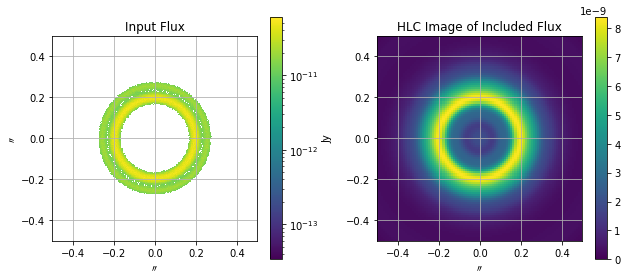

113.42096614837646

Running file number 2.
Running disk through HLC ...

Input file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_GAP\gap_inc30_r0.2.fits

Output file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels_HLC\Model_GAP\gap_inc30_r0.2_HLC_5.fits

Thresh = 5
local zodi: 0

load_existing keyword False, throwing error to regenerate file.


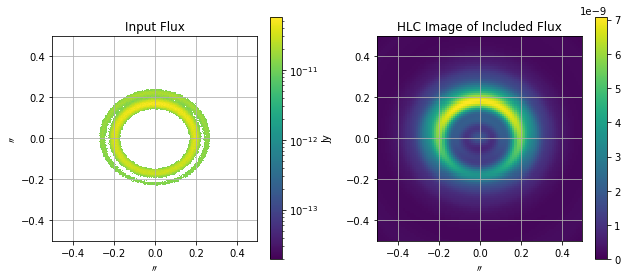

82.81426310539246

Running file number 3.
Running disk through HLC ...

Input file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_GAP\gap_inc45_r0.2.fits

Output file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels_HLC\Model_GAP\gap_inc45_r0.2_HLC_5.fits

Thresh = 5
local zodi: 0

load_existing keyword False, throwing error to regenerate file.


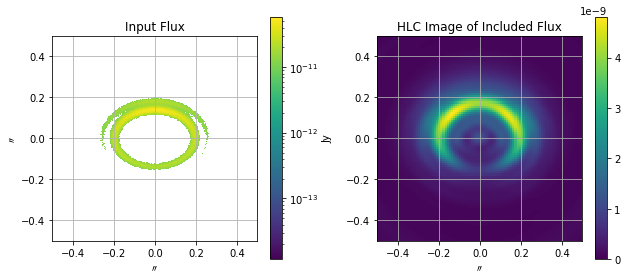

51.1558563709259

Running file number 4.
Running disk through HLC ...

Input file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_GAP\gap_inc60_r0.2.fits

Output file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels_HLC\Model_GAP\gap_inc60_r0.2_HLC_5.fits

Thresh = 5
local zodi: 0

load_existing keyword False, throwing error to regenerate file.


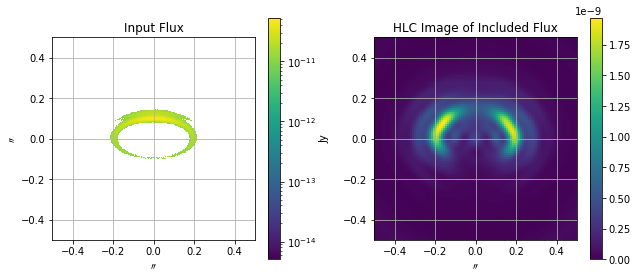

25.09097647666931

Running file number 5.
Running disk through HLC ...

Input file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_GAP\gap_inc89_r0.2.fits

Output file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels_HLC\Model_GAP\gap_inc89_r0.2_HLC_50000.fits

Thresh = 50000
local zodi: 0

load_existing keyword False, throwing error to regenerate file.


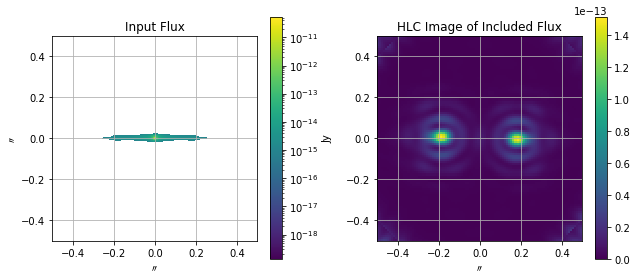

13.01904845237732
285.5041513442993



In [81]:
reload(disk_processing)

start_time = time.time()

for i,fitsfile in enumerate(dmodels_G):
    
    start = time.time()
    print("\nRunning file number {}.".format(i+1))
    
    im,zodi,outfits = disk_processing.disk_through_hlc(fitsfile,
                                                       my_interpolating_function,
                                                       xmas,
                                                       HLC_plate_scale_AS,
                                                       n = 128,
                                                       thresh=5,
                                                       display=True)
    
    fits.writeto(outfits, im, overwrite = True)
    end = time.time()
    print(end-start)
    
end_time = time.time()

print(str(end_time - start_time) + "\n")